In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np
import scipy.stats as sps
from tqdm import tqdm

from collections import OrderedDict

In [2]:
import elfi

In [3]:
from abc_reconstruction.model import Model
from abc_reconstruction.utils import PriorPosition  #, cart_to_pol, pol_to_cart
from abc_reconstruction.prior import BoundedNormal_x, BoundedNormal_y

You don't have ROOT or root_pandas, root truth file output is disabled


# Init model

In [4]:
model = Model('XENON1T_ABC_all_pmts_on.ini')  #, coordinate_system = 'polar')

In [5]:
min_model = Model('XENON1T_ABC_all_pmts_on_minimal.ini')

In [6]:
model.change_defaults(s2_electrons = 25, z=-0)
min_model.change_defaults(s2_electrons = 25, z=-0)

In [7]:
model.output_timing = True
min_model.output_timing = True

In [8]:
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '50',
 's2_electrons': '25',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0'}

In [9]:
#es = [min_model(0,0).sum() for _ in tqdm(range(100))]

In [10]:
#np.array(es).mean()

In [11]:
prior_mean = PriorPosition()

In [12]:
true_pos = np.loadtxt('data/truepos')

In [13]:
# Profiling test
#import cProfile

In [14]:
#cProfile.run('min_model(0,0)')  #, filename='profile_min_model00.cprof', sort='cumtime')

In [15]:
#%timeit -n 20 model(0,0)

In [16]:
#%timeit -n 20 min_model(0,0)

# Select pattern to reconstruct

In [17]:
# The true position of the hitpattern
#truth = np.array([0, 47.9])
truth = true_pos[0]
print(truth)

[  2.62643434 -17.96082368]


In [18]:
#cart_to_pol(*true_pos[0])

In [19]:
# The hitpattern to reconstruct
#data = model(*cart_to_pol(*true_pos[0]))
data = model(*truth)
# What pax thinks of this hitpattern
pax_pos = model.get_latest_pax_position()
# The prior mean (not used)
prior_pos = prior_mean(data['energy']) 

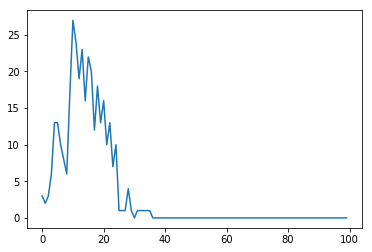

In [20]:
plt.plot(data['time'])

In [21]:
pax_pos

{'PosRecNeuralNet': {'x': 3.554940079469264, 'y': -18.439971936694263},
 'PosRecTopPatternFit': {'x': 2.618421052631575, 'y': -19.077067669172934}}

In [22]:
prior_pos

(4.115222817130077, -15.358220637996187)

In [23]:
#prior_pos_pol = cart_to_pol(*prior_pos)

In [24]:
from pax.configuration import load_configuration

config = load_configuration('XENON1T')
pmt_config = config['DEFAULT']['pmts']
tpc_r = config['DEFAULT']['tpc_radius']
        
# PMT positions
xs_top = [pmt['position']['x'] for pmt in pmt_config][:127]
ys_top = [pmt['position']['y'] for pmt in pmt_config][:127]

def plot_hp(pat):
    plt.figure(figsize=(10,8))
    plt.scatter(xs_top, ys_top, c=pat[:127], s=800, norm = LogNorm())
    plt.colorbar(label="Energy per PMT [pe]")
    plt.gca().set_aspect(1)
    plt.xlim(-tpc_r-5, tpc_r+5)
    plt.ylim(-tpc_r-5, tpc_r+5)
    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')

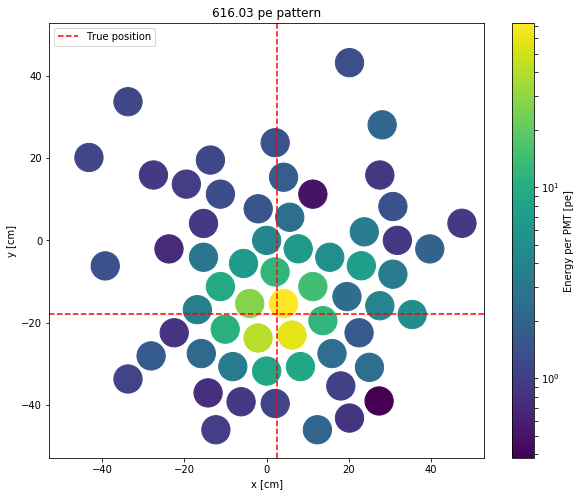

In [25]:
plot_hp(data['energy'])
# Add True position
plt.axhline(truth[1], color='red', linestyle='--', label='True position')
plt.axvline(truth[0], color='red', linestyle='--')
plt.title('%.2f pe pattern' % np.sum(data['energy']))

# Add markers for the reconstructed pax position
#if not pos_dict == {}:
#    for (marker, algo) in [('D', 'PosRecNeuralNet'), ('o', 'PosRecTopPatternFit')]:
#        plt.plot(pos_dict[algo]['x'], pos_dict[algo]['y'], marker=marker, label=algo)

plt.legend(loc='upper left')
#plt.savefig('hitpattern_0.png', dpi=150)
plt.show()

# Build ELFI Priors

In [26]:
r_bound = 47.9  # 47.9

In [27]:
prior_pos

(4.115222817130077, -15.358220637996187)

In [28]:
px = elfi.Prior(BoundedNormal_x, r_bound, prior_pos, 64)
py = elfi.Prior(BoundedNormal_y, px, r_bound, prior_pos, 64)

## Get PMT mask

In [29]:
pmt_mask = model.pmt_mask[:248].astype(int)

In [30]:
pmt_mask

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1])

# Build BOLFI Model

In [31]:
min_model=elfi.tools.vectorize(min_model)

In [32]:
Y = elfi.Simulator(min_model, px, py, observed=np.array([data]))

In [33]:
# Test calling FM
#elfi.Simulator.generate(Y)

## Define Distance functions

In [34]:
#def likelihood_chisquare(y, n, w=None):
#    if w is not None:
#        y = y[:,w.astype(bool)]
#        n = n[:,w.astype(bool)]
#
#    n = np.clip(n, 1e-5, None)
#    y = np.clip(y, 1e-5, None)
#    res = 2 * np.sum(y - n  + n * np.log(n/y), axis=1)
#    lres = np.log(res)
#    if lres > 10:
#        lres = np.ones(lres.shape) * 9
#    return lres

In [35]:
#from functools import partial

In [36]:
#likelihood_chisquare_masked = partial(likelihood_chisquare, w=pmt_mask)

In [37]:
#test = S2.generate(batch_size=3)
#test

In [38]:
#test[0]

In [39]:
#dt.generate()

In [40]:
def bc(x, d):
    return np.array([e[d] for e in x])

In [41]:
S1 = elfi.Summary(bc, Y, 'energy')
S2 = elfi.Summary(bc, Y, 'time')

In [42]:
de = elfi.Distance('braycurtis', S1)
dt = elfi.Distance('braycurtis', S2)
#log_de = elfi.Operation(np.log, de)
#log_dt = elfi.Operation(np.log, dt)
d = elfi.Operation(lambda a, b: (a**2 + b**2)**0.5, de, dt)

log_d = elfi.Operation(np.log, d)

# Distance cannot take weigths kwarg when passing callable instead of string, using functools instead
#log_d = elfi.Distance(likelihood_chisquare_masked, Y)

In [43]:
# Check Summary stat
#elfi.Simulator.generate(d)
#elfi.Simulator.generate(log_d)

In [44]:
# Load modified minimize function which we can pass different minimizer method and constraint.
from abc_reconstruction.utils import minimize, ConstraintLCBSC

In [45]:
from elfi.methods.bo.gpy_regression import GPyRegression
from elfi.methods.utils import ModelPrior

In [46]:
bounds = {'px':(-r_bound, r_bound), 'py':(-r_bound, r_bound)} 

In [47]:
# Define the default GP target model
target_model = GPyRegression(log_d.model.parameter_names, bounds=bounds)

# Define the custom acquisition method
acquisition_method = ConstraintLCBSC(target_model,
                                     prior = ModelPrior(log_d.model),
                                     noise_var = [0.1, 0.1],
                                     exploration_rate = 10,
                                     #seed=self.seed  # Use np.random
                                    )

In [48]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=1,
                   #bounds=bounds,  # Not used when using target_model
                   target_model = target_model,
                   acquisition_method = acquisition_method,
                   #acq_noise_var=[0.1, 0.1],  # Not used when using acquisition_method
                   #async=True,  # Could we use this?
                  )

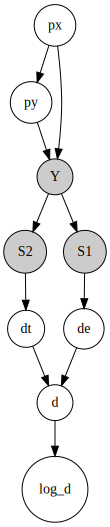

In [49]:
elfi.draw(px)  # , filename='graph_test', format='svg')

# Fit GP model

In [50]:
%time post = bolfi.fit(n_evidence=200)

CPU times: user 4min 59s, sys: 6min 44s, total: 11min 44s
Wall time: 2min 4s


In [51]:
# Test animation
#for b in range(1, 200):
#bolfi.set_objective(n_evidence=200)  # b
#bolfi.iterate()  # Calls update()
#bolfi.plot_state()
#    plt.savefig('bolfi_surface_%03d.png' % b, dpi=150)
#bolfi.infer(n_evidence=100, vis=dict(xlim=(-r_bound, r_bound), ylim=(-r_bound, r_bound)))

In [52]:
bolfi.target_model


Name : GP regression
Objective : -34.24715607786979
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |     priors    
  sum.rbf.variance         |   0.03999810559858698  |      +ve      |   Ga(0.04, 1) 
  sum.rbf.lengthscale      |     26.91516636819078  |      +ve      |    Ga(32, 1)  
  sum.bias.variance        |  0.016032704718822358  |      +ve      |  Ga(0.0099, 1)
  Gaussian_noise.variance  |  0.032394110336586644  |      +ve      |               

<Figure size 432x288 with 0 Axes>

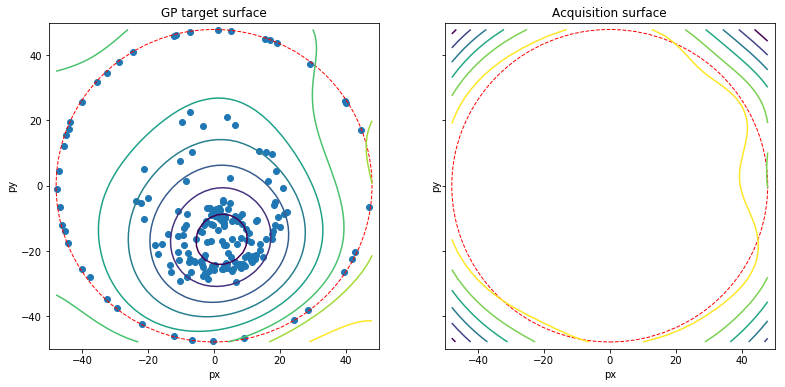

In [53]:
bolfi.plot_state()
plt.xlim(-50, 50)
plt.ylim(-50, 50)
for ax in plt.gcf().axes:
    ax.add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
#plt.savefig('surface_constraint_edge_noise.png', dpi=150)
#plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd23048208>,
      dtype=object)

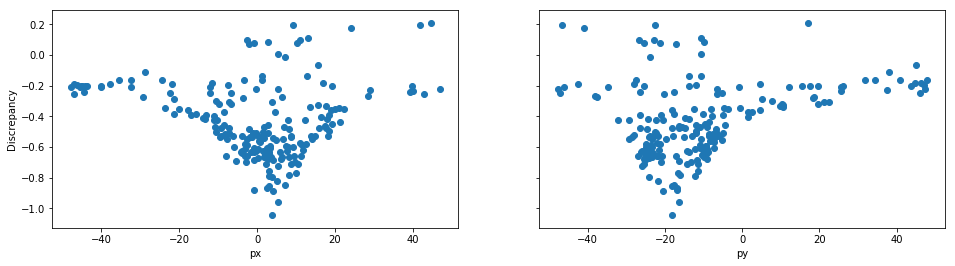

In [54]:
bolfi.plot_discrepancy()
#plt.savefig('euclidean_edge_noise.png', dpi=150)

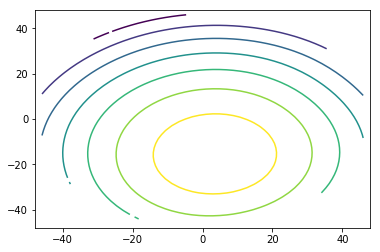

In [55]:
post.plot(logpdf=True)

# Sample from GP model

In [56]:
#bolfi.sample?

In [57]:
#%time result_BOLFI = bolfi.sample(500, warmup=100, n_chains=8, info_freq=500)  # 500/100 23s, 1000/500 4 45s, 
%time result_BOLFI = bolfi.sample(1000, info_freq=1000)  

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
px 3086.366019157926 0.9998108643228589
py 3137.7100659654216 0.9994552248487671
CPU times: user 1min 52s, sys: 1min 31s, total: 3min 24s
Wall time: 50.8 s


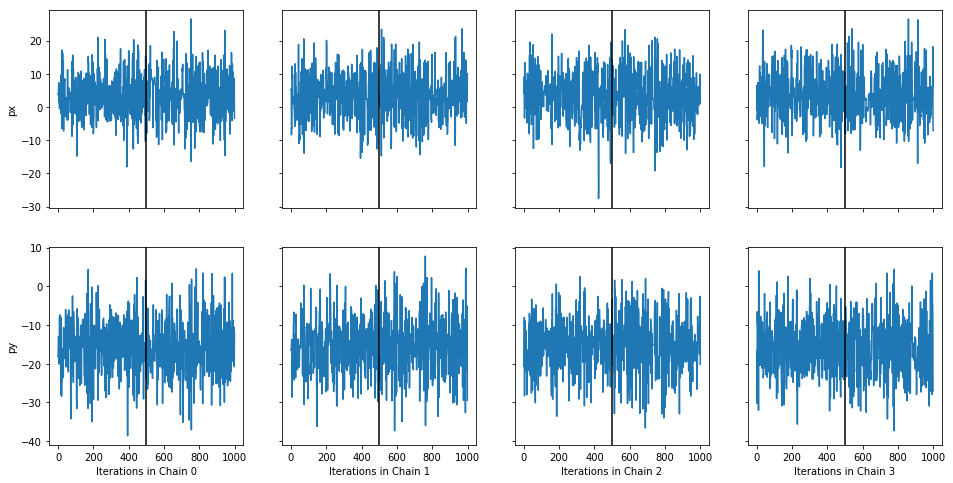

In [58]:
result_BOLFI.plot_traces();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd16051748>,
      dtype=object)

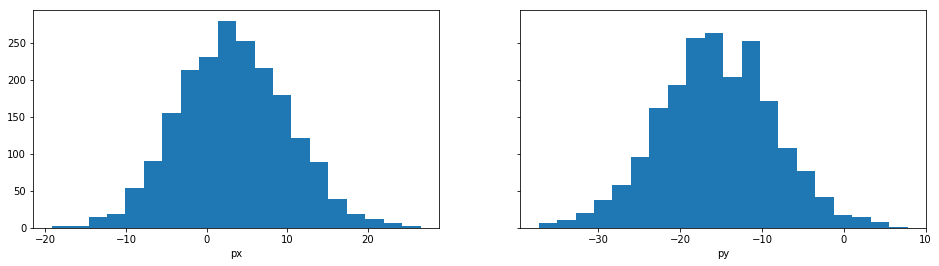

In [59]:
result_BOLFI.plot_marginals()

In [60]:
res = OrderedDict()
res['mean'] = [result_BOLFI.sample_means['px'], result_BOLFI.sample_means['py']]
res['median'] = bolfi_median = np.median(result_BOLFI.samples_array, axis=0)
res['mode'] = sps.mode(result_BOLFI.samples_array).mode[0]
res['truth'] = truth
res['tpf'] = [pax_pos['PosRecTopPatternFit']['x'], pax_pos['PosRecTopPatternFit']['y']]
res['nn'] = [pax_pos['PosRecNeuralNet']['x'], pax_pos['PosRecNeuralNet']['y']]

for k, v in res.items():
    if k == 'truth':
        print('%s:\t x=%.2f cm,\t y=%.2f cm' % (k, v[0], v[1]))
    else:
        d = ((truth[0] - v[0])**2 + (truth[1] -  v[1])**2)**0.5
        print('%s:\t x=%.2f cm,\t y=%.2f cm,\t d_truth=%.2f cm' % (k, v[0], v[1], d))


mean:	 x=3.28 cm,	 y=-15.56 cm,	 d_truth=2.49 cm
median:	 x=3.02 cm,	 y=-15.63 cm,	 d_truth=2.36 cm
mode:	 x=2.31 cm,	 y=-15.05 cm,	 d_truth=2.93 cm
truth:	 x=2.63 cm,	 y=-17.96 cm
tpf:	 x=2.62 cm,	 y=-19.08 cm,	 d_truth=1.12 cm
nn:	 x=3.55 cm,	 y=-18.44 cm,	 d_truth=1.04 cm
